# 🔍 LLM 기반 리뷰 심층 분석

## 분석 목표
- **긍정 리뷰 속 숨은 부정 요소 발굴**
- **시설/서비스/맛 3차원 심층 분석**
- **맥락 기반 미묘한 불만사항 추출**

## 데이터
- 파일: 아리계곡_통합.csv
- 총 리뷰 수: 2,697건
- 지점: 강남, 건대, 종각, 한양대

## 사용 모델
- OpenAI GPT-4o-mini (빠르고 경제적)

---
## 1. 환경 설정

In [1]:
# 필요 라이브러리 설치 (최초 1회만)
# !pip install openai python-dotenv pandas tqdm matplotlib seaborn wordcloud

In [2]:
import os
import json
import time
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm.auto import tqdm
from dotenv import load_dotenv
from openai import OpenAI
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Apple SD Gothic Neo'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# .env 파일에서 API 키 로드
load_dotenv()

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
OPENAI_MODEL = os.getenv('OPENAI_MODEL', 'gpt-4o-mini')

if not OPENAI_API_KEY:
    raise ValueError("❌ OPENAI_API_KEY가 .env 파일에 설정되지 않았습니다!")

# OpenAI 클라이언트 초기화
client = OpenAI(api_key=OPENAI_API_KEY)

print(f"✅ OpenAI API 로드 완료")
print(f"📌 사용 모델: {OPENAI_MODEL}")

✅ OpenAI API 로드 완료
📌 사용 모델: gpt-4o-mini


---
## 2. 데이터 로드

In [4]:
# 리뷰 데이터 로드
df = pd.read_csv('아리계곡_통합.csv')

print(f"📊 총 리뷰 수: {len(df):,}건")
print(f"📍 지점별 분포:")
print(df['지점명'].value_counts())
print(f"\n⏰ 웨이팅 시간 분포:")
print(df['wait_time'].value_counts())

📊 총 리뷰 수: 2,697건
📍 지점별 분포:
지점명
강남점     1310
종각점      843
건대점      420
한양대점     124
Name: count, dtype: int64

⏰ 웨이팅 시간 분포:
wait_time
바로 입장      2239
10분 이내      179
30분 이내      164
30분 이상       74
1시간 이상       38
2시간 이상        3
Name: count, dtype: int64


In [5]:
# 샘플 리뷰 확인
df.head(10)

,지점명,date,nickname,review_content,wait_time
0,강남점,2025년 7월 22일 화요일,임구임구,닭을 샤브샤브처럼 먹는것도 새롭고 메뉴가 다 맛있어서 이것저것 엄청 먹어봤어요!소곱...,바로 입장
1,강남점,2025년 6월 26일 목요일,8비버찡8,보양식 + 보양술.. 나는 건강해지러 여기온다..^ㅠ^✅ 메뉴 : 2인 진흙오리전병...,바로 입장
2,강남점,2025년 7월 27일 일요일,여니4894,여기 일요일에가도 사람이 정말 많네요..! 진짜 강남역맛집인듯합니다..!! 운좋게 ...,바로 입장
3,강남점,2025년 7월 9일 수요일,jay****,주종도 다양하고 주종에 맞는 안주도 다양해서 넘 좋아요!!메뉴하나하나 맛있고 가성비...,바로 입장
4,강남점,2025년 6월 30일 월요일,dusdn20,강남에서 보양 제대로 하고 싶을 때 찐추천! 맑고 깊은 맛의 ‘원조닭전골’ 국물 진...,바로 입장
5,강남점,2025년 7월 8일 화요일,땡몬,처음 가본 곳인데 비주얼부터 완전히 시선을 사로잡았습니다.고기를 통째로 걸어서 소스...,바로 입장
6,강남점,2025년 7월 28일 월요일,Hannahislove,오리 진짜 맛나요 ㅠㅠ 가성비 미쵸따 !분위기도 좋고 친절하셔서 또 오고 싶은 집이...,바로 입장
7,강남점,2025년 7월 26일 토요일,yzzz9914,분위기 좋고 힙하고 쾌적해요 안주도 딱 좋아요!! 닭안심은 샤브샤브로 먹으면 되고 ...,10분 이내
8,강남점,2025년 5월 29일 목요일,liliS2,"3명이서 와서 보양세트 주문했는데, 세트 구성이 너무 좋아요!👍🏻 닭전골, 통돼지후...",바로 입장
9,강남점,2025년 7월 29일 화요일,요해니,팀 회식으로 왔는데 이 무더운 여름날 시원한 계곡 놀러온 듯한 느낌에 엄청 가성비 ...,바로 입장


In [6]:
# 결측치 확인
print("🔍 결측치 확인:")
print(df.isnull().sum())

# review_content가 없는 행 제거
df = df.dropna(subset=['review_content'])
print(f"\n✅ 유효 리뷰 수: {len(df):,}건")

🔍 결측치 확인:
지점명                0
date               0
nickname           0
review_content    72
wait_time          0
dtype: int64

✅ 유효 리뷰 수: 2,625건


---
## 3. LLM 프롬프트 설계

In [7]:
# 분석 프롬프트 템플릿
ANALYSIS_PROMPT = """
당신은 음식점 고객 리뷰 분석 전문가입니다.

다음 리뷰를 **시설**, **서비스**, **맛** 3가지 측면에서 심층 분석하세요.

**중요**: 전체적으로 긍정적인 리뷰라도, 숨어있는 불만이나 개선점을 놓치지 말고 찾아주세요.
예: "분위기는 좋은데 사람이 너무 많아요" → 시설 긍정, 서비스 부정(혼잡)

---
**리뷰 내용:**
{review_content}
---

다음 JSON 형식으로 응답하세요:

{{
  "시설": {{
    "점수": -5에서 +5 사이 정수 (매우 부정: -5, 중립: 0, 매우 긍정: +5),
    "긍정키워드": ["분위기 좋음", "인테리어 예쁨", ...],
    "부정키워드": ["좁음", "시끄러움", ...],
    "구체적언급": "리뷰에서 시설 관련 구체적 언급 내용 요약"
  }},
  "서비스": {{
    "점수": -5에서 +5 사이 정수,
    "긍정키워드": ["친절함", "빠른 서빙", ...],
    "부정키워드": ["웨이팅 김", "불친절", ...],
    "구체적언급": "서비스 관련 언급 요약"
  }},
  "맛": {{
    "점수": -5에서 +5 사이 정수,
    "긍정키워드": ["맛있음", "신선함", "양 많음", ...],
    "부정키워드": ["짜요", "별로", "양 적음", ...],
    "구체적언급": "맛 관련 언급 요약 (특정 메뉴명 포함)"
  }},
  "숨은불만": "전체적으로 긍정적이지만 발견된 미묘한 불만사항이나 개선점. 없으면 null",
  "전체요약": "리뷰의 핵심 내용을 1-2문장으로 요약"
}}

**규칙:**
1. 언급이 없는 항목은 점수 0, 키워드는 빈 리스트
2. 키워드는 최대 5개까지만
3. 반드시 유효한 JSON 형식으로 응답
4. 한국어로 응답
"""

---
## 4. 단일 리뷰 분석 함수

In [8]:
def analyze_single_review(review_content, model=OPENAI_MODEL, max_retries=3):
    """
    단일 리뷰를 LLM으로 분석
    
    Args:
        review_content: 리뷰 텍스트
        model: 사용할 OpenAI 모델
        max_retries: 최대 재시도 횟수
    
    Returns:
        dict: 분석 결과 (시설/서비스/맛 점수 및 키워드)
    """
    
    # 빈 리뷰 처리
    if not review_content or pd.isna(review_content):
        return None
    
    # 프롬프트 생성
    prompt = ANALYSIS_PROMPT.format(review_content=review_content)
    
    for attempt in range(max_retries):
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": "당신은 고객 리뷰 분석 전문가입니다. 항상 유효한 JSON 형식으로 응답하세요."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.3,  # 일관성을 위해 낮은 temperature
                response_format={"type": "json_object"}  # JSON 모드 강제
            )
            
            # JSON 파싱
            result = json.loads(response.choices[0].message.content)
            return result
            
        except json.JSONDecodeError as e:
            print(f"⚠️  JSON 파싱 오류 (시도 {attempt+1}/{max_retries}): {e}")
            if attempt == max_retries - 1:
                return None
            time.sleep(1)
            
        except Exception as e:
            print(f"⚠️  API 오류 (시도 {attempt+1}/{max_retries}): {e}")
            if attempt == max_retries - 1:
                return None
            time.sleep(2)
    
    return None

### 테스트: 샘플 리뷰 1개 분석

In [9]:
# 샘플 리뷰로 테스트
sample_review = df.iloc[0]['review_content']
print("📝 테스트 리뷰:")
print(sample_review)
print("\n" + "="*80 + "\n")

# 분석 실행
test_result = analyze_single_review(sample_review)

if test_result:
    print("✅ 분석 성공!\n")
    print(json.dumps(test_result, ensure_ascii=False, indent=2))
else:
    print("❌ 분석 실패")

📝 테스트 리뷰:
닭을 샤브샤브처럼 먹는것도 새롭고 메뉴가 다 맛있어서 이것저것 엄청 먹어봤어요!소곱창순두부전걸도 맛있었는데 흡입하니라 사진이 없는정도 ㅋㅋㅋ강남 술 모임 하실때 아주 괜찮습니다👍🏻👍🏻더보기




✅ 분석 성공!

{
  "시설": {
    "점수": 0,
    "긍정키워드": [],
    "부정키워드": [],
    "구체적언급": "리뷰에서 시설 관련 구체적 언급이 없음"
  },
  "서비스": {
    "점수": 0,
    "긍정키워드": [],
    "부정키워드": [],
    "구체적언급": "리뷰에서 서비스 관련 구체적 언급이 없음"
  },
  "맛": {
    "점수": 5,
    "긍정키워드": [
      "맛있음",
      "신선함"
    ],
    "부정키워드": [],
    "구체적언급": "닭을 샤브샤브처럼 먹는 것이 새롭고, 소곱창순두부전골이 맛있다고 언급"
  },
  "숨은불만": null,
  "전체요약": "닭을 샤브샤브처럼 먹는 새로운 경험과 다양한 메뉴의 맛이 좋다고 평가하며, 강남에서의 술 모임에 적합하다고 언급함."
}


---
## 5. 배치 분석 함수

In [10]:
def batch_analyze_reviews(df, start_idx=0, end_idx=None, save_interval=100, checkpoint_file='analysis_checkpoint.csv'):
    """
    여러 리뷰를 배치로 분석
    
    Args:
        df: 리뷰 데이터프레임
        start_idx: 시작 인덱스
        end_idx: 종료 인덱스 (None이면 전체)
        save_interval: 중간 저장 주기
        checkpoint_file: 체크포인트 파일명
    
    Returns:
        DataFrame: 분석 결과가 추가된 데이터프레임
    """
    
    if end_idx is None:
        end_idx = len(df)
    
    # 기존 체크포인트 확인
    if os.path.exists(checkpoint_file):
        print(f"📂 기존 체크포인트 발견: {checkpoint_file}")
        checkpoint_df = pd.read_csv(checkpoint_file)
        print(f"✅ {len(checkpoint_df)}건 이미 분석됨")
        
        # 이미 분석된 인덱스 건너뛰기
        analyzed_indices = set(checkpoint_df.index)
    else:
        checkpoint_df = df.copy()
        analyzed_indices = set()
        
        # 결과 컬럼 초기화
        for col in ['시설_점수', '시설_긍정키워드', '시설_부정키워드', '시설_언급',
                    '서비스_점수', '서비스_긍정키워드', '서비스_부정키워드', '서비스_언급',
                    '맛_점수', '맛_긍정키워드', '맛_부정키워드', '맛_언급',
                    '숨은불만', '전체요약']:
            checkpoint_df[col] = None
    
    # 분석 진행
    total = end_idx - start_idx
    success_count = 0
    fail_count = 0
    
    with tqdm(total=total, desc="🔍 리뷰 분석 중") as pbar:
        for idx in range(start_idx, end_idx):
            # 이미 분석된 항목은 건너뛰기
            if idx in analyzed_indices:
                pbar.update(1)
                continue
            
            review_content = df.iloc[idx]['review_content']
            
            # 분석 실행
            result = analyze_single_review(review_content)
            
            if result:
                # 결과 저장
                try:
                    checkpoint_df.loc[idx, '시설_점수'] = result.get('시설', {}).get('점수', 0)
                    checkpoint_df.loc[idx, '시설_긍정키워드'] = ', '.join(result.get('시설', {}).get('긍정키워드', []))
                    checkpoint_df.loc[idx, '시설_부정키워드'] = ', '.join(result.get('시설', {}).get('부정키워드', []))
                    checkpoint_df.loc[idx, '시설_언급'] = result.get('시설', {}).get('구체적언급', '')
                    
                    checkpoint_df.loc[idx, '서비스_점수'] = result.get('서비스', {}).get('점수', 0)
                    checkpoint_df.loc[idx, '서비스_긍정키워드'] = ', '.join(result.get('서비스', {}).get('긍정키워드', []))
                    checkpoint_df.loc[idx, '서비스_부정키워드'] = ', '.join(result.get('서비스', {}).get('부정키워드', []))
                    checkpoint_df.loc[idx, '서비스_언급'] = result.get('서비스', {}).get('구체적언급', '')
                    
                    checkpoint_df.loc[idx, '맛_점수'] = result.get('맛', {}).get('점수', 0)
                    checkpoint_df.loc[idx, '맛_긍정키워드'] = ', '.join(result.get('맛', {}).get('긍정키워드', []))
                    checkpoint_df.loc[idx, '맛_부정키워드'] = ', '.join(result.get('맛', {}).get('부정키워드', []))
                    checkpoint_df.loc[idx, '맛_언급'] = result.get('맛', {}).get('구체적언급', '')
                    
                    checkpoint_df.loc[idx, '숨은불만'] = result.get('숨은불만', '')
                    checkpoint_df.loc[idx, '전체요약'] = result.get('전체요약', '')
                    
                    success_count += 1
                except Exception as e:
                    print(f"⚠️  결과 저장 오류 (인덱스 {idx}): {e}")
                    fail_count += 1
            else:
                fail_count += 1
            
            # 중간 저장
            if (idx + 1) % save_interval == 0:
                checkpoint_df.to_csv(checkpoint_file, index=False)
                pbar.set_postfix({'성공': success_count, '실패': fail_count, '체크포인트': '저장됨'})
            
            pbar.update(1)
            
            # Rate limiting (API 제한 회피)
            time.sleep(0.5)  # 초당 2건 정도
    
    # 최종 저장
    checkpoint_df.to_csv(checkpoint_file, index=False)
    
    print(f"\n✅ 분석 완료!")
    print(f"   성공: {success_count}건")
    print(f"   실패: {fail_count}건")
    print(f"   파일 저장: {checkpoint_file}")
    
    return checkpoint_df

---
## 6. 분석 실행

### ⚠️ 주의사항
- 전체 2,697건 분석 시 약 **30분~1시간** 소요
- 예상 비용: 약 **$2~5** (gpt-4o-mini 기준)
- 중간에 중단되어도 체크포인트에서 재개 가능

In [11]:
# 분석 모드 선택
MODE = 'sample'  # 'sample' 또는 'full'

if MODE == 'sample':
    # 샘플 모드: 최근 100건만 분석
    print("🧪 샘플 모드: 최근 100건 분석")
    result_df = batch_analyze_reviews(
        df, 
        start_idx=0, 
        end_idx=100,
        checkpoint_file='analysis_checkpoint_sample.csv'
    )
else:
    # 전체 모드: 모든 리뷰 분석
    print("🚀 전체 모드: 전체 리뷰 분석")
    confirm = input(f"정말 {len(df)}건 전체를 분석하시겠습니까? (yes/no): ")
    
    if confirm.lower() == 'yes':
        result_df = batch_analyze_reviews(
            df,
            checkpoint_file='analysis_checkpoint_full.csv'
        )
    else:
        print("❌ 분석 취소됨")

🧪 샘플 모드: 최근 100건 분석


🔍 리뷰 분석 중:   0%|          | 0/100 [00:00<?, ?it/s]


✅ 분석 완료!
   성공: 100건
   실패: 0건
   파일 저장: analysis_checkpoint_sample.csv


---
## 7. 결과 확인

In [12]:
# 분석 결과 로드 (이미 분석된 파일이 있는 경우)
# result_df = pd.read_csv('analysis_checkpoint_sample.csv')
# result_df = pd.read_csv('analysis_checkpoint_full.csv')

In [13]:
# 결과 미리보기
result_df[['지점명', 'review_content', '시설_점수', '서비스_점수', '맛_점수', '숨은불만']].head(20)

,지점명,review_content,시설_점수,서비스_점수,맛_점수,숨은불만
0,강남점,닭을 샤브샤브처럼 먹는것도 새롭고 메뉴가 다 맛있어서 이것저것 엄청 먹어봤어요!소곱...,0,0,5,None
1,강남점,보양식 + 보양술.. 나는 건강해지러 여기온다..^ㅠ^✅ 메뉴 : 2인 진흙오리전병...,3,2,4,저녁 시간대 혼잡함과 웨이팅 발생 가능성.
2,강남점,여기 일요일에가도 사람이 정말 많네요..! 진짜 강남역맛집인듯합니다..!! 운좋게 ...,-1,0,5,일요일에 혼잡한 점은 개선이 필요할 수 있음.
3,강남점,주종도 다양하고 주종에 맞는 안주도 다양해서 넘 좋아요!!메뉴하나하나 맛있고 가성비...,4,0,5,None
4,강남점,강남에서 보양 제대로 하고 싶을 때 찐추천! 맑고 깊은 맛의 ‘원조닭전골’ 국물 진...,0,0,5,None
5,강남점,처음 가본 곳인데 비주얼부터 완전히 시선을 사로잡았습니다.고기를 통째로 걸어서 소스...,0,0,5,None
6,강남점,오리 진짜 맛나요 ㅠㅠ 가성비 미쵸따 !분위기도 좋고 친절하셔서 또 오고 싶은 집이...,4,4,5,None
7,강남점,분위기 좋고 힙하고 쾌적해요 안주도 딱 좋아요!! 닭안심은 샤브샤브로 먹으면 되고 ...,4,0,4,막걸리 종류가 더 많으면 좋겠다는 의견이 있음
8,강남점,"3명이서 와서 보양세트 주문했는데, 세트 구성이 너무 좋아요!👍🏻 닭전골, 통돼지후...",4,5,5,None
9,강남점,팀 회식으로 왔는데 이 무더운 여름날 시원한 계곡 놀러온 듯한 느낌에 엄청 가성비 ...,4,0,5,None


In [14]:
# 기본 통계
print("📊 점수 통계:")
print(result_df[['시설_점수', '서비스_점수', '맛_점수']].describe())

📊 점수 통계:
        시설_점수  서비스_점수  맛_점수
count     100     100   100
unique      7       7     4
top         0       0     5
freq       37      71    75


---
## 8. 인사이트 추출 & 시각화

### 8.1 지점별 점수 비교

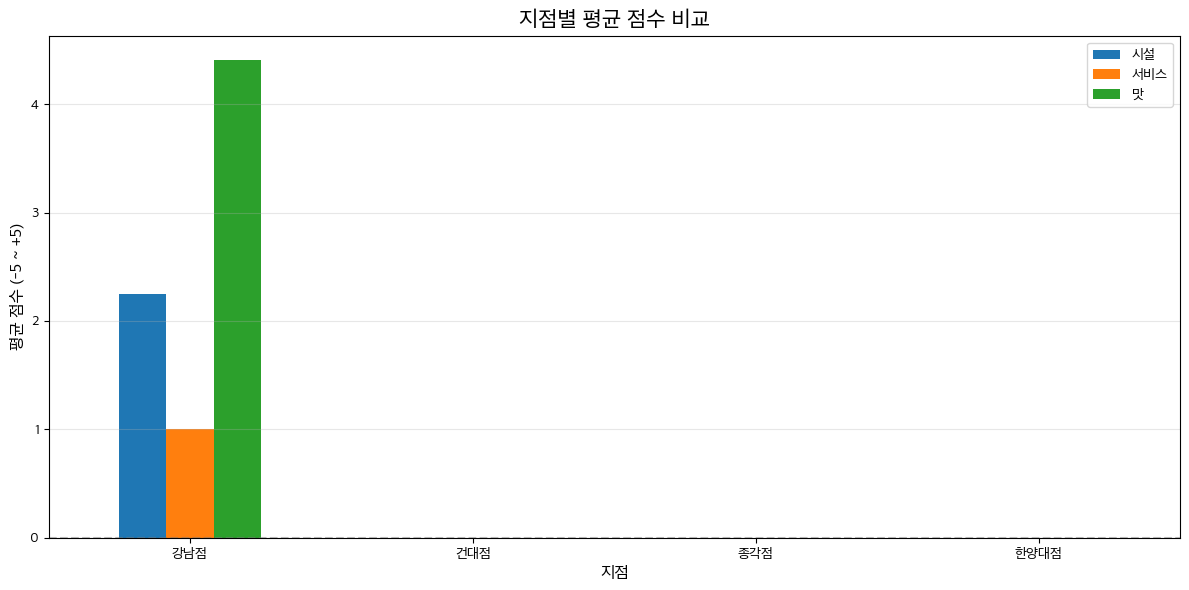


📌 지점별 평균 점수:
     시설_점수 서비스_점수  맛_점수
지점명                    
강남점   2.25    1.0  4.41
건대점    NaN    NaN   NaN
종각점    NaN    NaN   NaN
한양대점   NaN    NaN   NaN


In [15]:
# 지점별 평균 점수
branch_scores = result_df.groupby('지점명')[['시설_점수', '서비스_점수', '맛_점수']].mean()

# 시각화
fig, ax = plt.subplots(figsize=(12, 6))
branch_scores.plot(kind='bar', ax=ax)
ax.set_title('지점별 평균 점수 비교', fontsize=16, fontweight='bold')
ax.set_xlabel('지점', fontsize=12)
ax.set_ylabel('평균 점수 (-5 ~ +5)', fontsize=12)
ax.legend(['시설', '서비스', '맛'], fontsize=10)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n📌 지점별 평균 점수:")
print(branch_scores.round(2))

### 8.2 부정 키워드 Top 20

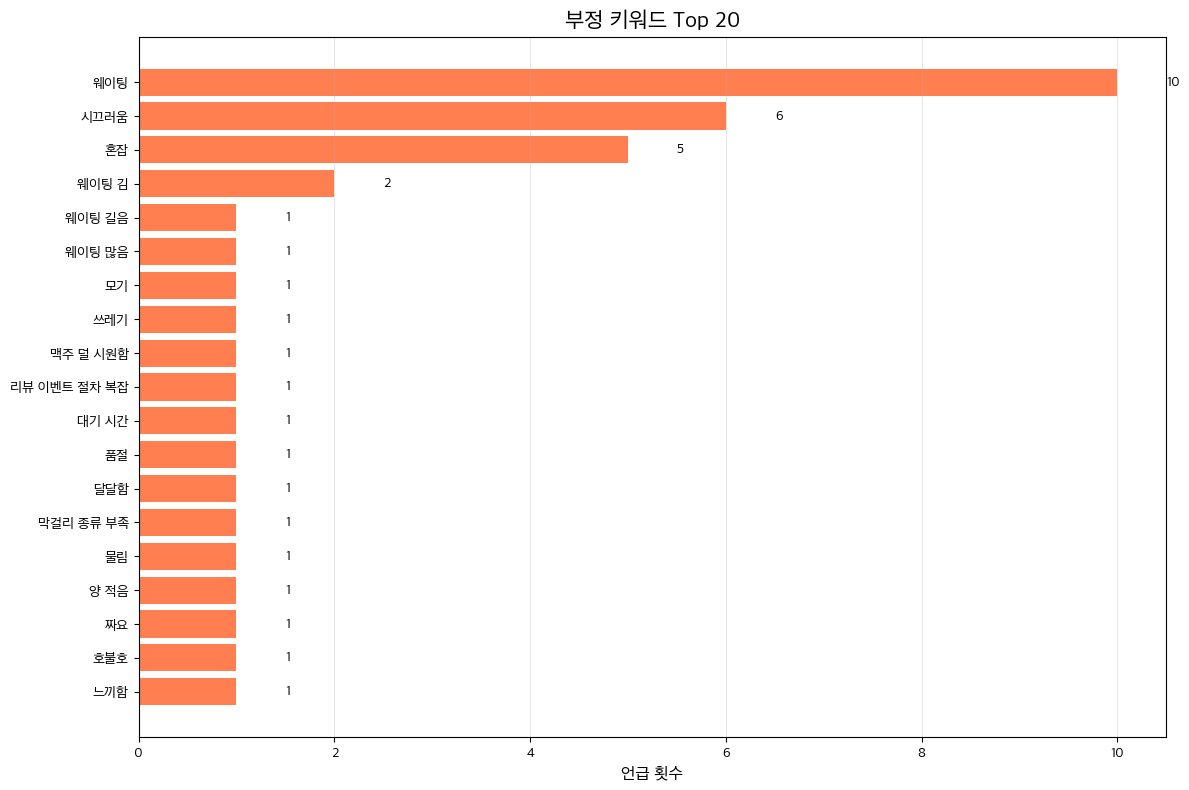


🔴 가장 많이 언급된 부정 키워드:
  웨이팅: 10회
  시끄러움: 6회
  혼잡: 5회
  웨이팅 김: 2회
  웨이팅 길음: 1회
  웨이팅 많음: 1회
  모기: 1회
  쓰레기: 1회
  맥주 덜 시원함: 1회
  리뷰 이벤트 절차 복잡: 1회


In [16]:
# 모든 부정 키워드 수집
all_negative_keywords = []

for col in ['시설_부정키워드', '서비스_부정키워드', '맛_부정키워드']:
    keywords = result_df[col].dropna().str.split(', ').sum()
    all_negative_keywords.extend([k.strip() for k in keywords if k.strip()])

# 빈도 계산
negative_counter = Counter(all_negative_keywords)
top_negative = negative_counter.most_common(20)

# 시각화
if top_negative:
    keywords, counts = zip(*top_negative)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.barh(range(len(keywords)), counts, color='coral')
    ax.set_yticks(range(len(keywords)))
    ax.set_yticklabels(keywords)
    ax.invert_yaxis()
    ax.set_xlabel('언급 횟수', fontsize=12)
    ax.set_title('부정 키워드 Top 20', fontsize=16, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # 값 표시
    for i, v in enumerate(counts):
        ax.text(v + 0.5, i, str(v), va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print("\n🔴 가장 많이 언급된 부정 키워드:")
    for keyword, count in top_negative[:10]:
        print(f"  {keyword}: {count}회")
else:
    print("부정 키워드가 발견되지 않았습니다.")

### 8.3 "숨은 불만" 사례 추출

In [17]:
# 숨은 불만이 있는 리뷰 필터링
hidden_complaints = result_df[result_df['숨은불만'].notna() & (result_df['숨은불만'] != '')]

print(f"🔍 숨은 불만이 발견된 리뷰: {len(hidden_complaints)}건")
print("\n📌 대표 사례:")

for idx, row in hidden_complaints.head(10).iterrows():
    print(f"\n[리뷰 {idx+1}] {row['지점명']}")
    print(f"원문: {row['review_content'][:100]}...")
    print(f"숨은 불만: {row['숨은불만']}")
    print("-" * 80)

🔍 숨은 불만이 발견된 리뷰: 25건

📌 대표 사례:

[리뷰 2] 강남점
원문: 보양식 + 보양술.. 나는 건강해지러 여기온다..^ㅠ^✅ 메뉴 : 2인 진흙오리전병세트(원조닭전골 + 진흙오리전병), 오미자하이볼 병, 동학✅ 웨이팅 : 목욜 저녁 6:40 웨이팅...
숨은 불만: 저녁 시간대 혼잡함과 웨이팅 발생 가능성.
--------------------------------------------------------------------------------

[리뷰 3] 강남점
원문: 여기 일요일에가도 사람이 정말 많네요..! 진짜 강남역맛집인듯합니다..!! 운좋게 웨이팅은 안했고요!! 원기세트랑 묵은지볶음밥먹었는데 너무 맛있었어요! 원기세트에 나오는 닭전골.....
숨은 불만: 일요일에 혼잡한 점은 개선이 필요할 수 있음.
--------------------------------------------------------------------------------

[리뷰 8] 강남점
원문: 분위기 좋고 힙하고 쾌적해요 안주도 딱 좋아요!! 닭안심은 샤브샤브로 먹으면 되고 먹기도 편해요! 막걸리 종류가 더 많으면 좋겠어요...
숨은 불만: 막걸리 종류가 더 많으면 좋겠다는 의견이 있음
--------------------------------------------------------------------------------

[리뷰 12] 강남점
원문: 다양하게 먹고 싶어서 2인세트 시켰는데 맛있고 구성도 좋아요!근데 육회보다는 오이무침하세요..육회가 진짜 제일 맛있었는데 육회+닭전골+닭전 조합은 물리더라구요ㅜ 아니면 다른 세트 ...
숨은 불만: 육회는 맛있지만, 세트 구성의 조합이 물린다는 점에서 개선이 필요할 수 있음
--------------------------------------------------------------------------------

[리뷰 14] 강남점
원문: 강남에서 이런 요리는 처음 먹어보는데왜 사람이 많

### 8.4 차원별 점수 분포

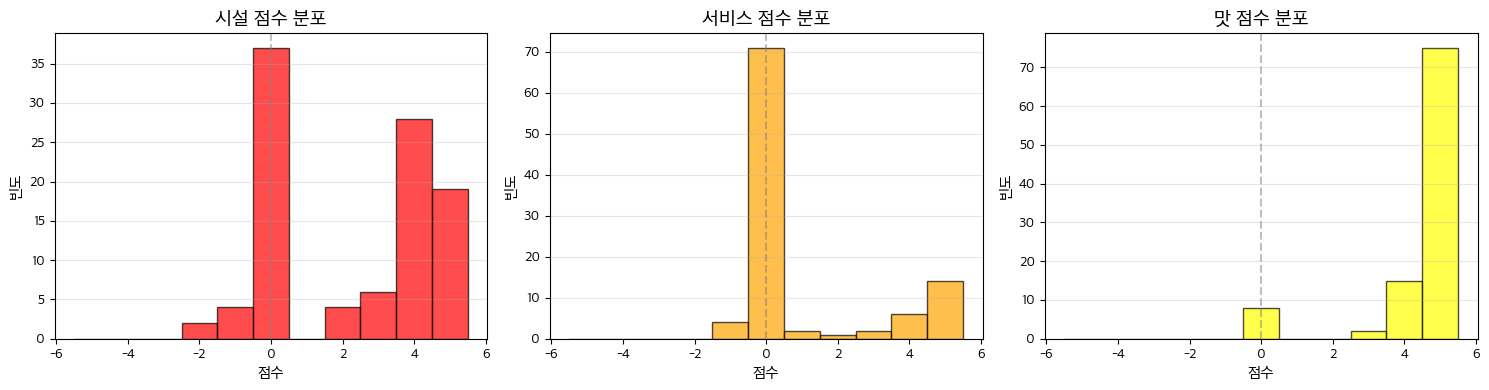

In [18]:
# 점수 분포 히스토그램
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (col, title) in enumerate([('시설_점수', '시설'), ('서비스_점수', '서비스'), ('맛_점수', '맛')]):
    axes[idx].hist(result_df[col].dropna(), bins=11, range=(-5.5, 5.5), color=['red', 'orange', 'yellow', 'lightgreen', 'green'][idx % 5], alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'{title} 점수 분포', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('점수', fontsize=11)
    axes[idx].set_ylabel('빈도', fontsize=11)
    axes[idx].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 8.5 긍정 키워드 Top 20

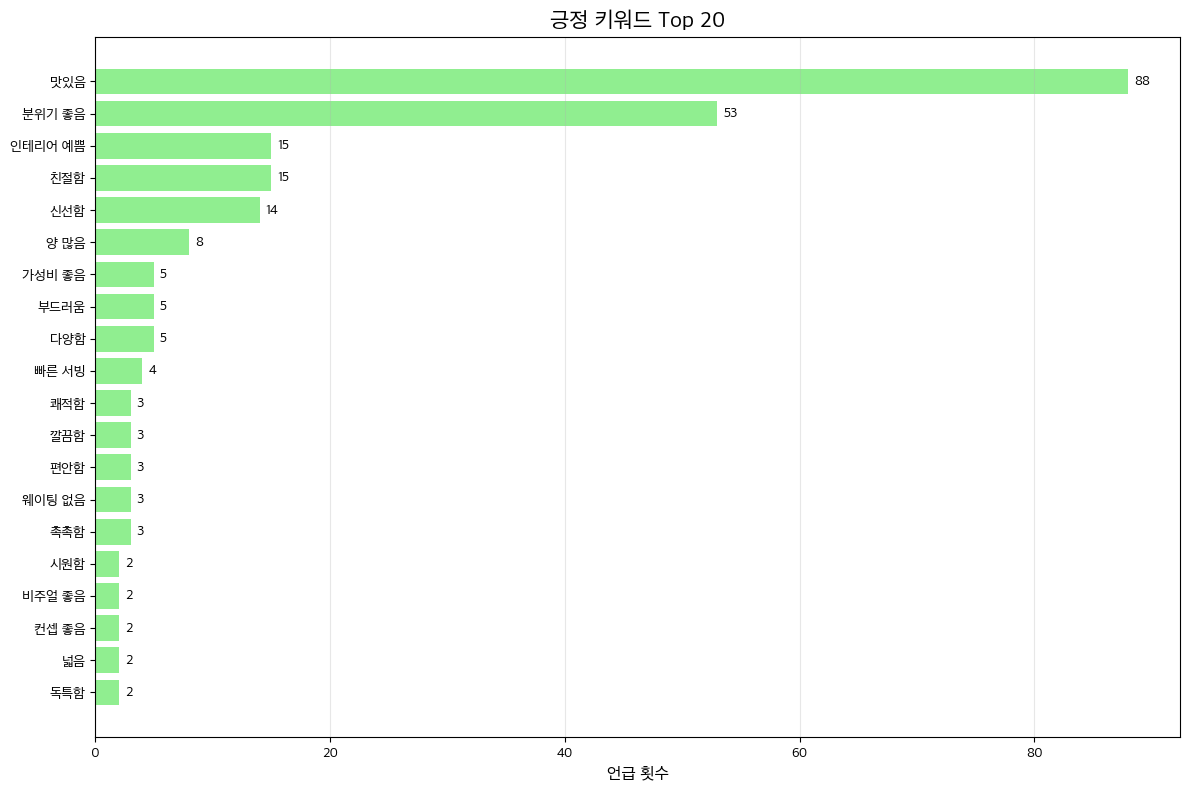


🟢 가장 많이 언급된 긍정 키워드:
  맛있음: 88회
  분위기 좋음: 53회
  인테리어 예쁨: 15회
  친절함: 15회
  신선함: 14회
  양 많음: 8회
  가성비 좋음: 5회
  부드러움: 5회
  다양함: 5회
  빠른 서빙: 4회


In [19]:
# 모든 긍정 키워드 수집
all_positive_keywords = []

for col in ['시설_긍정키워드', '서비스_긍정키워드', '맛_긍정키워드']:
    keywords = result_df[col].dropna().str.split(', ').sum()
    all_positive_keywords.extend([k.strip() for k in keywords if k.strip()])

# 빈도 계산
positive_counter = Counter(all_positive_keywords)
top_positive = positive_counter.most_common(20)

# 시각화
if top_positive:
    keywords, counts = zip(*top_positive)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.barh(range(len(keywords)), counts, color='lightgreen')
    ax.set_yticks(range(len(keywords)))
    ax.set_yticklabels(keywords)
    ax.invert_yaxis()
    ax.set_xlabel('언급 횟수', fontsize=12)
    ax.set_title('긍정 키워드 Top 20', fontsize=16, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # 값 표시
    for i, v in enumerate(counts):
        ax.text(v + 0.5, i, str(v), va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print("\n🟢 가장 많이 언급된 긍정 키워드:")
    for keyword, count in top_positive[:10]:
        print(f"  {keyword}: {count}회")

### 8.6 개선 우선순위 도출


📊 개선 우선순위 (부정 언급 비율):
  1. 시설: 6.0%
  2. 서비스: 4.0%
  3. 맛: 0.0%


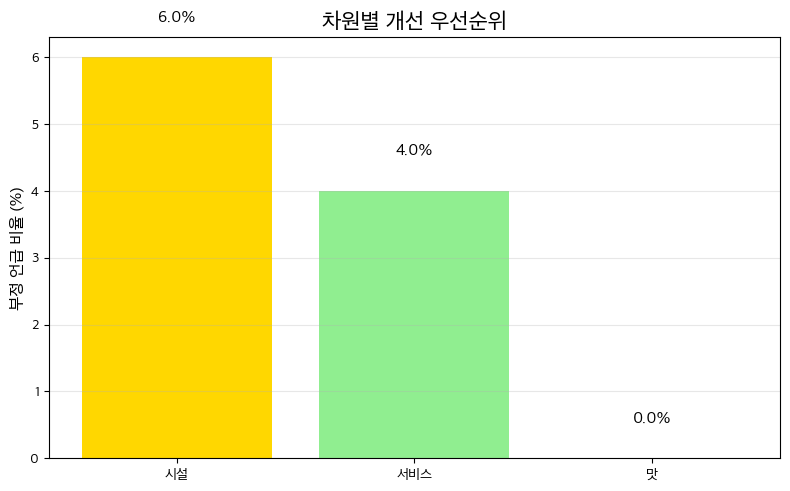

In [20]:
# 차원별 부정 언급 비율 계산
negative_ratio = {}

for dimension in ['시설', '서비스', '맛']:
    negative_count = (result_df[f'{dimension}_점수'] < 0).sum()
    total_count = result_df[f'{dimension}_점수'].notna().sum()
    
    if total_count > 0:
        ratio = negative_count / total_count * 100
        negative_ratio[dimension] = ratio

# 정렬
priority = sorted(negative_ratio.items(), key=lambda x: x[1], reverse=True)

print("\n📊 개선 우선순위 (부정 언급 비율):")
for idx, (dimension, ratio) in enumerate(priority, 1):
    print(f"  {idx}. {dimension}: {ratio:.1f}%")

# 시각화
dimensions, ratios = zip(*priority)
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(dimensions, ratios, color=['coral' if r > 10 else 'gold' if r > 5 else 'lightgreen' for r in ratios])
ax.set_ylabel('부정 언급 비율 (%)', fontsize=12)
ax.set_title('차원별 개선 우선순위', fontsize=16, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# 값 표시
for i, v in enumerate(ratios):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### 8.7 최종 리포트 생성

In [21]:
# 최종 분석 결과 저장
output_file = 'review_analysis_final.csv'
result_df.to_csv(output_file, index=False)

print(f"\n✅ 최종 분석 결과 저장 완료: {output_file}")
print(f"\n" + "="*80)
print("📊 분석 요약")
print("="*80)
print(f"총 분석 리뷰 수: {len(result_df)}건")
print(f"\n평균 점수:")
print(f"  - 시설: {result_df['시설_점수'].mean():.2f}")
print(f"  - 서비스: {result_df['서비스_점수'].mean():.2f}")
print(f"  - 맛: {result_df['맛_점수'].mean():.2f}")

if top_negative:
    print(f"\n가장 많이 언급된 부정 키워드 Top 5:")
    for keyword, count in top_negative[:5]:
        print(f"  - {keyword} ({count}회)")

print(f"\n숨은 불만 발견 건수: {len(hidden_complaints)}건")
print("="*80)


✅ 최종 분석 결과 저장 완료: review_analysis_final.csv

📊 분석 요약
총 분석 리뷰 수: 2625건

평균 점수:
  - 시설: 2.25
  - 서비스: 1.00
  - 맛: 4.41

가장 많이 언급된 부정 키워드 Top 5:
  - 웨이팅 (10회)
  - 시끄러움 (6회)
  - 혼잡 (5회)
  - 웨이팅 김 (2회)
  - 웨이팅 길음 (1회)

숨은 불만 발견 건수: 25건


---
## 9. 추가 분석 (선택사항)

### 9.1 날짜별 만족도 추이

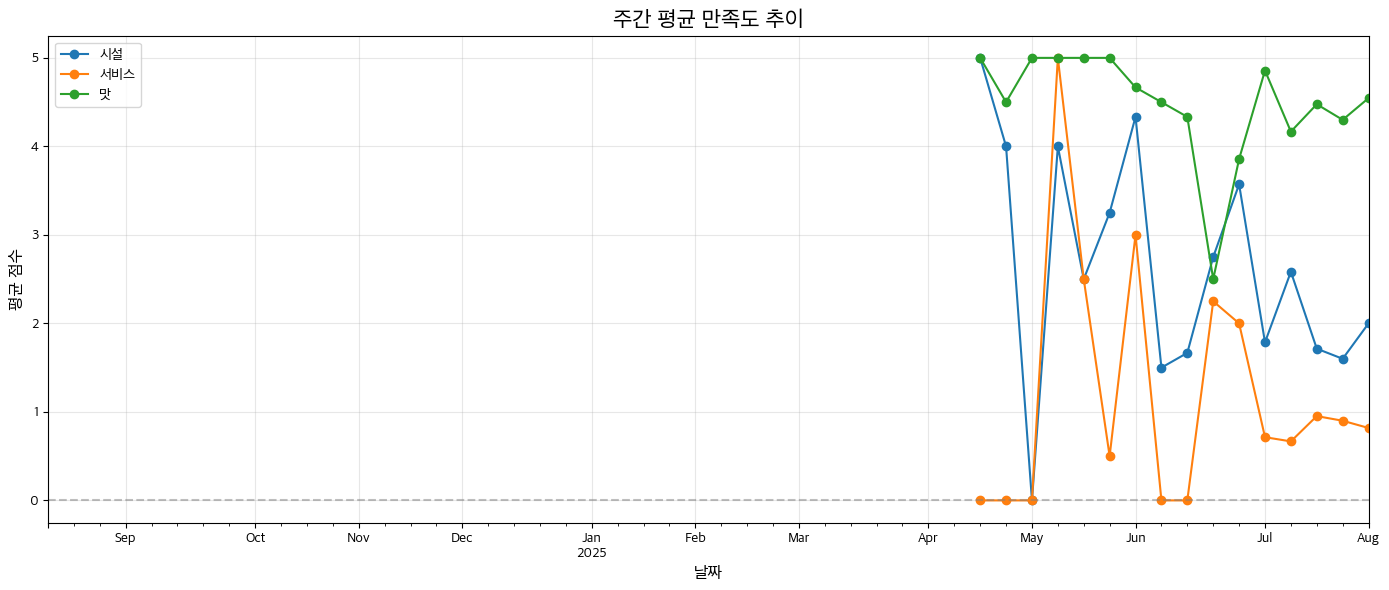

In [22]:
# 날짜 파싱 (한글 날짜를 datetime으로 변환)
import re
from datetime import datetime

def parse_korean_date(date_str):
    """한글 날짜를 datetime으로 변환"""
    try:
        # "2025년 7월 22일 화요일" → "2025-07-22"
        match = re.search(r'(\d{4})년\s*(\d{1,2})월\s*(\d{1,2})일', date_str)
        if match:
            year, month, day = match.groups()
            return datetime(int(year), int(month), int(day))
    except:
        pass
    return None

result_df['날짜'] = result_df['date'].apply(parse_korean_date)
result_df_sorted = result_df.sort_values('날짜')

# 주간 평균 계산
result_df_sorted.set_index('날짜', inplace=True)
weekly_avg = result_df_sorted[['시설_점수', '서비스_점수', '맛_점수']].resample('W').mean()

# 시각화
fig, ax = plt.subplots(figsize=(14, 6))
weekly_avg.plot(ax=ax, marker='o')
ax.set_title('주간 평균 만족도 추이', fontsize=16, fontweight='bold')
ax.set_xlabel('날짜', fontsize=12)
ax.set_ylabel('평균 점수', fontsize=12)
ax.legend(['시설', '서비스', '맛'])
ax.grid(alpha=0.3)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 인덱스 리셋
result_df.reset_index(inplace=True)

### 9.2 특정 메뉴 언급 분석


🍽️  메뉴별 언급 통계:
         언급횟수  평균_맛점수
전골      278.0    4.54
닭전골     175.0    4.41
오리      144.0    4.88
하이볼     103.0    4.62
육회       44.0    4.50
오리전병     36.0    4.80
복분자      11.0    5.00
묵은지볶음밥    9.0    4.75
똥집        8.0    5.00


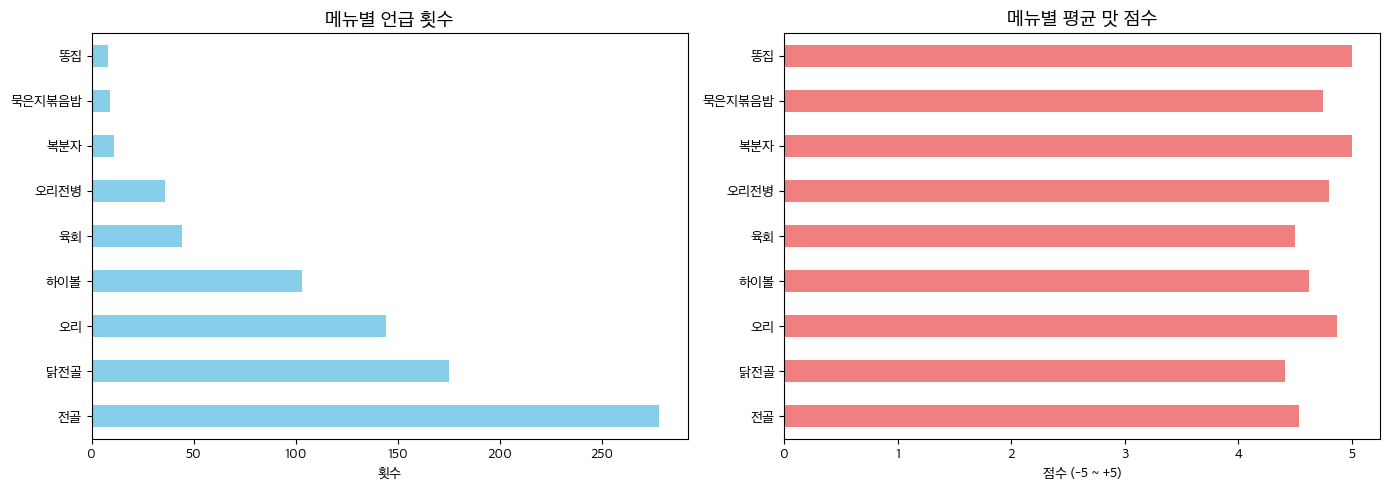

In [23]:
# 주요 메뉴 키워드
menu_keywords = ['닭전골', '오리전병', '하이볼', '육회', '묵은지볶음밥', '전골', '똥집', '오리', '복분자']

# 메뉴별 언급 횟수 및 평균 맛 점수
menu_stats = {}

for menu in menu_keywords:
    # 해당 메뉴가 언급된 리뷰 필터링
    mentioned = result_df[result_df['review_content'].str.contains(menu, na=False)]
    
    if len(mentioned) > 0:
        menu_stats[menu] = {
            '언급횟수': len(mentioned),
            '평균_맛점수': mentioned['맛_점수'].mean()
        }

# 데이터프레임으로 변환
menu_df = pd.DataFrame(menu_stats).T.sort_values('언급횟수', ascending=False)

print("\n🍽️  메뉴별 언급 통계:")
print(menu_df.round(2))

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 언급 횟수
menu_df['언급횟수'].plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_title('메뉴별 언급 횟수', fontsize=14, fontweight='bold')
axes[0].set_xlabel('횟수')

# 평균 맛 점수
menu_df['평균_맛점수'].plot(kind='barh', ax=axes[1], color='lightcoral')
axes[1].set_title('메뉴별 평균 맛 점수', fontsize=14, fontweight='bold')
axes[1].set_xlabel('점수 (-5 ~ +5)')
axes[1].axvline(x=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

---
## 🎯 최종 결론 및 제안

위 분석 결과를 바탕으로 다음과 같은 인사이트를 도출할 수 있습니다:

1. **강점**: 긍정 키워드 분석 결과
2. **개선점**: 부정 키워드 및 숨은 불만 분석 결과
3. **우선순위**: 차원별 부정 비율이 높은 영역부터 개선
4. **지점별 차이**: 각 지점의 특성에 맞는 맞춤 전략 수립

### 추가 분석 제안:
- 웨이팅 시간과 만족도 상관관계 분석
- 특정 이벤트/프로모션 효과 분석
- 경쟁사 리뷰와 비교 분석